In [ ]:
# In this notebook we import the data from our experiments, map it, add distance between probes and do some preliminary analysis
import pandas as pd
import numpy  as np
import json
import os 

# plotting
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [ ]:
# Retrieve the measurement files from ripe-atlas
import requests
import json

# Set your RIPE-ATLAS API key
api_key = os.getenv('RIPE_ATLAS_API_KEY')

# Set the measurement IDs you want to retrieve
measurement_ids = ["53182861","53182848","53182842","53182834","53182731"]

# Loop through the measurement IDs and retrieve the JSON files
for measurement_id in measurement_ids:
        url = f"https://atlas.ripe.net/api/v2/measurements/{measurement_id}/results/?format=json"
        headers = {"Authorization": f"Bearer {api_key}"}
        response = requests.get(url, headers=headers)

        # Check if the request was successful
        if response.status_code == 200:
                json_data = response.json()
                
                # Write the JSON data to a file
                with open(f"{measurement_id}.json", "w") as f:
                        json.dump(json_data, f, indent=4)
                        
        else:
                print(f"Failed to retrieve measurement {measurement_id}. Error code: {response.status_code}")

In [3]:

# Loop through the measurement IDs and create a DataFrame for each
dfs = []
for measurement_id in measurement_ids:
    # Read the JSON data from the file
    with open(f"{measurement_id}.json", "r") as f:
        json_data = json.load(f)
    
    # Normalize the JSON data into a pandas DataFrame
    df = pd.json_normalize(json_data)
    
    # Append the DataFrame to the list of DataFrames
    dfs.append(df)

# Concatenate all the DataFrames into a single one
result_df = pd.concat(dfs, ignore_index=True)

# Print the resulting DataFrame
result_df.head()


,fw,mver,lts,endtime,dst_name,dst_addr,src_addr,proto,af,size,...,result,msm_id,prb_id,timestamp,msm_name,from,type,group_id,stored_timestamp,destination_ip_responded
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,"[{'hop': 1, 'result': [{'from': '192.168.192.1...",53182861,15118,1683307728,Traceroute,80.39.148.125,traceroute,53182861,1683307808,NaN
1,4770,NaN,63,1683307731,81.34.11.86,81.34.11.86,192.168.1.8,ICMP,4,48,...,"[{'hop': 1, 'result': [{'from': '192.168.1.1',...",53182861,33627,1683307715,Traceroute,79.154.49.145,traceroute,53182861,1683307777,NaN
2,5080,2.6.2,79,1683307761,81.34.11.86,81.34.11.86,172.16.30.2,ICMP,4,48,...,"[{'hop': 1, 'result': [{'from': '172.16.30.1',...",53182861,51265,1683307725,Traceroute,79.150.158.173,traceroute,53182861,1683307863,NaN
3,5080,2.6.2,2,1683307762,81.34.11.86,81.34.11.86,192.168.1.62,ICMP,4,48,...,"[{'hop': 1, 'result': [{'from': '192.168.1.1',...",53182861,55787,1683307722,Traceroute,79.152.112.253,traceroute,53182861,1683307938,NaN
4,5080,2.6.2,48,1683307733,81.34.11.86,81.34.11.86,192.168.0.177,ICMP,4,48,...,"[{'hop': 1, 'result': [{'from': '192.168.0.254...",53182861,61357,1683307720,Traceroute,81.32.64.14,traceroute,53182861,1683307860,NaN


In [4]:
#converting from epoch time to ordinary time 
from datetime import datetime
new_timestamp = []

for i in result_df['timestamp']:
    my_datetime = datetime.fromtimestamp(i)
    new_timestamp.append(my_datetime)
    
result_df['new_time'] = new_timestamp

In [5]:
# Adding a distance column for all probes and all destinations 
# first we add a probe id column for the destination 
dest_prb_id = []
for value in result_df['dst_addr']:
    if value == '79.145.127.11':
        dest_prb_id .append('26072')
    if value == '83.51.50.60':
        dest_prb_id .append('30381')
    if value == '83.43.248.213':
        dest_prb_id .append("15632")
    if value == '88.24.67.177':
        dest_prb_id .append("1004200")
    if value == '81.34.11.86':
        dest_prb_id .append("14866")

        
result_df["dst_id"] = dest_prb_id

In [6]:
# Renaming the dest probe_id column for easy plotting 
dprb_id = []

for value in result_df["dst_id"]:
    if value == '26072':
        dprb_id.append('Malaga')
    if value == '30381':
        dprb_id.append('Dst_Barcelona')
    if value == '15632':
        dprb_id.append('Dst_Barcelona2')
    if value == '1004200':
        dprb_id.append('Canary Islands')
    if value == '14866':
        dprb_id.append('Madrid')
        
        
result_df["dst_names"] = dprb_id

In [7]:
# Renaming the source probe_id column for easy plotting 
sprb_id = []

for value in result_df["prb_id"]:
    if value == 33627:
        sprb_id.append('src_Barcelona')
    if value == 51265:
        sprb_id.append('Mallorca')
    if value == 55787:
        sprb_id.append('src_Barcelona2')
    if value == 61357:
        sprb_id.append('Oviedo')
    if value == 15118:
        sprb_id.append('src_Madrid')
        
result_df["src_names"] = sprb_id

In [8]:
#extracting the hour from new_time for plot 
Timestamp = pd.to_datetime(result_df['new_time'])

# Extract the hour 
result_df['Hour'] = Timestamp.dt.hour

In [9]:
# Collect the source probe information 

from ripe.atlas.cousteau import Probe  

probe_id_list = [33627, 51265, 55787, 61357, 15118]

#extract the probe cordinates from ripe atlas 
probe_coordinates = []
probe_country = []

for id_i in probe_id_list:
    probe = Probe(id=id_i) # Obtains all metadata of probe id_i
    print(probe.geometry) #probe.geometry is a GeoJSON https://en.wikipedia.org/wiki/GeoJSON
    probe_coordinates.append(probe.geometry['coordinates']) # saving to the list
    probe_country.append(probe.country_code)

longitude = []
latitude = []

for i in probe_coordinates:
    longitude.append(i[0])
    latitude.append(i[1])

# create a probe metadata dataframe
srcprobes_df = pd.DataFrame({'prb_id': probe_id_list,'longitude': longitude, 'latitude': latitude,'probe_country': probe_country})
srcprobes_df

{'type': 'Point', 'coordinates': [2.1885, 41.4005]}
{'type': 'Point', 'coordinates': [3.0905, 39.8495]}
{'type': 'Point', 'coordinates': [2.1615, 41.4105]}
{'type': 'Point', 'coordinates': [-5.7005, 43.3105]}
{'type': 'Point', 'coordinates': [-3.6725, 40.4515]}


,prb_id,longitude,latitude,probe_country
0,33627,2.1885,41.4005,ES
1,51265,3.0905,39.8495,ES
2,55787,2.1615,41.4105,ES
3,61357,-5.7005,43.3105,ES
4,15118,-3.6725,40.4515,ES


In [10]:
# Collect the destination probe information 
probe_id_list = [26072, 30381, 15632, 1004200, 14866]

#extract the probe cordinates from ripe atlas 
probe_coordinates = []
probe_country = []

for id_i in probe_id_list:
    probe = Probe(id=id_i) # Obtains all metadata of probe id_i
    print(probe.geometry) #probe.geometry is a GeoJSON https://en.wikipedia.org/wiki/GeoJSON
    probe_coordinates.append(probe.geometry['coordinates']) # saving to the list
    probe_country.append(probe.country_code)

longitude = []
latitude = []

for i in probe_coordinates:
    longitude.append(i[0])
    latitude.append(i[1])

# create a probe metadata dataframe
dstprobes_df = pd.DataFrame({'prb_id': probe_id_list,'longitude': longitude, 'latitude': latitude,'probe_country': probe_country})
dstprobes_df

{'type': 'Point', 'coordinates': [-4.5095, 36.6185]}
{'type': 'Point', 'coordinates': [2.1415, 41.3775]}
{'type': 'Point', 'coordinates': [2.0885, 41.4685]}
{'type': 'Point', 'coordinates': [-15.5025, 28.0275]}
{'type': 'Point', 'coordinates': [-3.6495, 40.5405]}


,prb_id,longitude,latitude,probe_country
0,26072,-4.5095,36.6185,ES
1,30381,2.1415,41.3775,ES
2,15632,2.0885,41.4685,ES
3,1004200,-15.5025,28.0275,ES
4,14866,-3.6495,40.5405,ES


In [11]:
distance_combined = pd.concat([srcprobes_df, dstprobes_df], ignore_index=True)
distance_combined

,prb_id,longitude,latitude,probe_country
0,33627,2.1885,41.4005,ES
1,51265,3.0905,39.8495,ES
2,55787,2.1615,41.4105,ES
3,61357,-5.7005,43.3105,ES
4,15118,-3.6725,40.4515,ES
5,26072,-4.5095,36.6185,ES
6,30381,2.1415,41.3775,ES
7,15632,2.0885,41.4685,ES
8,1004200,-15.5025,28.0275,ES
9,14866,-3.6495,40.5405,ES


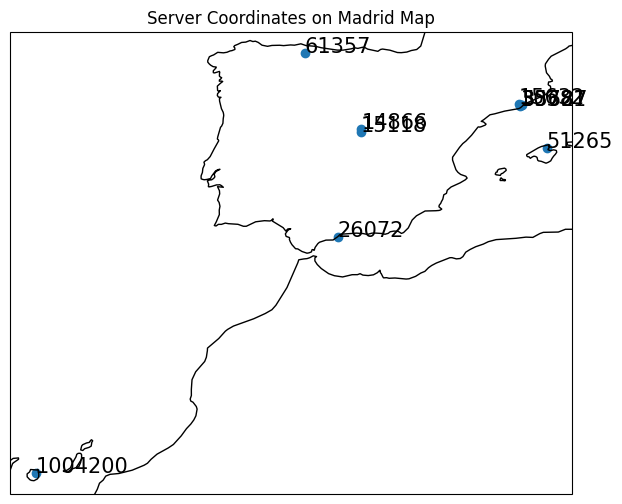

In [12]:
import cartopy.crs as ccrs

# Create a map using PlateCarree projection (a simple cylindrical projection)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8,6))

# Scatter plot for latitude and longitude on the world map
ax.scatter(distance_combined['longitude'], distance_combined['latitude'], transform=ccrs.PlateCarree())

# Annotate each point with the server label
for i, row in distance_combined.iterrows():
    ax.text(row['longitude'], row['latitude'], row['prb_id'], transform=ccrs.PlateCarree(), fontsize=15)

# Customize the map if needed
ax.set_title('Server Coordinates on Madrid Map')
ax.coastlines()

plt.show()

In [13]:
#calculate the distances between all possible source probe and destination probe pairs 
from geopy.distance import distance
from itertools import product

# Create an empty list to store the distances
data = []

# Iterate over each combination of source and destination probes
for source_row, dest_row in product(srcprobes_df.iterrows(), dstprobes_df.iterrows()):
    source_row = source_row[1]  # Get the row data from the iterator
    dest_row = dest_row[1]  # Get the row data from the iterator
    
    source_coordinates = (source_row['latitude'], source_row['longitude'])
    dest_coordinates = (dest_row['latitude'], dest_row['longitude'])
    
    distance_km = distance(source_coordinates, dest_coordinates).km
    # Append data to the list
    data.append({
        'source_prb_id': source_row['prb_id'],
        'source_longitude': source_row['longitude'],
        'source_latitude': source_row['latitude'],
        'destination_prb_id': dest_row['prb_id'],
        'destination_longitude': dest_row['longitude'],
        'destination_latitude': dest_row['latitude'],
        'distance': distance_km
    })

# Create a new dataframe from the data list
distance_df = pd.DataFrame(data)

# Print the new dataframe
distance_df.head()

distance_df.to_pickle('distance.pickle')

In [14]:
# Create a map from the distance dataframe and and use it to map distances to all probes and all destinations 

# Create a dictionary mapping (source_prb_id, destination_prb_id) to distance
distance_map = {(int(row['source_prb_id']), int(row['destination_prb_id'])): row['distance'] for _, row in distance_df.iterrows()}


# Map the distance values to the existing DataFrame based on (source_prb_id, destination_prb_id)
result_df['distance'] = result_df.apply(lambda row: distance_map.get((int(row['prb_id']), int(row['dst_id']))), axis=1)

# Display the updated DataFrame
distance_map

#export distance map to csv
#distance_df.to_csv('distance.csv')


{(33627, 26072): 785.9182258701823,
 (33627, 30381): 4.688058376244396,
 (33627, 15632): 11.264671696862758,
 (33627, 1004200): 2188.8800938712834,
 (33627, 14866): 500.4905665566352,
 (51265, 26072): 755.5115189765537,
 (51265, 30381): 187.72102450278626,
 (51265, 15632): 198.7499016305077,
 (51265, 1004200): 2154.39108906094,
 (51265, 14866): 578.8726975868892,
 (55787, 26072): 784.9188007851479,
 (55787, 30381): 4.028670355517181,
 (55787, 15632): 8.872164822772612,
 (55787, 1004200): 2187.750082677194,
 (55787, 14866): 498.4386521016615,
 (61357, 26072): 749.9514544313483,
 (61357, 30381): 680.6243777700602,
 (61357, 15632): 672.9147218100015,
 (61357, 1004200): 1910.620996030712,
 (61357, 14866): 351.5424128638219,
 (15118, 26072): 431.6951850745027,
 (15118, 30381): 500.3671331198224,
 (15118, 15632): 497.86660611750574,
 (15118, 1004200): 1753.4539743768942,
 (15118, 14866): 10.073428481540587}

In [15]:
# Processing the results column
int_df = result_df.explode("result")

# Extract the hop number from the result column
int_df["hop"] = int_df["result"].apply(lambda x: x.get("hop"))

# Extract the hop ip from the result column
int_df["hop_ip"] = int_df["result"].apply(lambda x: [r.get("from") for r in x.get("result", [])])

# add a new column for rtt
int_df["rtt"] = int_df["result"].apply(lambda x: [r.get("rtt") for r in x.get("result", [])])
    
#int_df_df = int_df[['prb_id','hop','hop_ip','rtt']]

# Replace all None values with NaN
int_df['rtt'] = int_df['rtt'].apply(lambda x: [np.nan if val is None else val for val in x])

# Extract only unique from hop_ip column
int_df["unique_ips"] = int_df["hop_ip"].apply(lambda x: list(set(x)))

# Calculate mean of each list
means = int_df['rtt'].apply(lambda x: np.nanmean(x))
int_df['avg_rtt'] = means
        
int_df.head()

/var/folders/fn/t1h5mchj4qg8nfdt2p1xfmwh0000gn/T/ipykernel_65395/3316049056.py:22: RuntimeWarning: Mean of empty slice
  means = int_df['rtt'].apply(lambda x: np.nanmean(x))


,fw,mver,lts,endtime,dst_name,dst_addr,src_addr,proto,af,size,...,dst_id,dst_names,src_names,Hour,distance,hop,hop_ip,rtt,unique_ips,avg_rtt
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,1,"[192.168.192.1, 192.168.192.1, 192.168.192.1]","[0.468, 0.418, 0.389]",[192.168.192.1],0.425000
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,2,"[192.168.144.1, 192.168.144.1, 192.168.144.1]","[1.308, 0.728, 0.789]",[192.168.144.1],0.941667
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,3,"[81.46.64.245, 81.46.64.245, 81.46.64.245]","[0.811, 1.758, 1.751]",[81.46.64.245],1.440000
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,4,"[81.46.64.206, 81.46.64.206, 81.46.64.206]","[2.119, 1.666, 1.707]",[81.46.64.206],1.830667
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,5,"[81.34.11.86, 81.34.11.86, 81.34.11.86]","[4.31, 3.306, 3.74]",[81.34.11.86],3.785333


In [16]:
int_df.to_pickle('traceroute.pickle')

In [17]:
#Extracting the new unique IPs in each experiment (all probes & all destinations ) and saving to csv 

#list to store all the values
all_values = []

# Iterate over each row in the 'unique_ids' column
for row in int_df['unique_ips']:
    # Iterate over each sublist in the row
    for sublist in row:
        if sublist is not None:
        # Append the all_values list with the elements from each sublist
            all_values.append(sublist)

# Filter out the unique values
unique_values = list(set(all_values))

# Create a DataFrame with the unique values
df_unique = pd.DataFrame(unique_values, columns=['Unique_Values'])

# Save the DataFrame to a CSV file
df_unique.to_csv('unique_ip_list.csv', index=False)

In [18]:
## Extracting the results  all probes to one destination
hop_df = int_df[(int_df['dst_id'] == "14866")]
hop_df

,fw,mver,lts,endtime,dst_name,dst_addr,src_addr,proto,af,size,...,dst_id,dst_names,src_names,Hour,distance,hop,hop_ip,rtt,unique_ips,avg_rtt
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,1,"[192.168.192.1, 192.168.192.1, 192.168.192.1]","[0.468, 0.418, 0.389]",[192.168.192.1],0.425000
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,2,"[192.168.144.1, 192.168.144.1, 192.168.144.1]","[1.308, 0.728, 0.789]",[192.168.144.1],0.941667
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,3,"[81.46.64.245, 81.46.64.245, 81.46.64.245]","[0.811, 1.758, 1.751]",[81.46.64.245],1.440000
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,4,"[81.46.64.206, 81.46.64.206, 81.46.64.206]","[2.119, 1.666, 1.707]",[81.46.64.206],1.830667
0,5080,2.6.2,20,1683307728,81.34.11.86,81.34.11.86,192.168.192.157,ICMP,4,48,...,14866,Madrid,src_Madrid,19,10.073428,5,"[81.34.11.86, 81.34.11.86, 81.34.11.86]","[4.31, 3.306, 3.74]",[81.34.11.86],3.785333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30330,5080,2.6.2,7,1704988762,81.34.11.86,81.34.11.86,192.168.0.119,ICMP,4,48,...,14866,Madrid,Oviedo,16,351.542413,4,"[81.41.254.222, 81.41.254.222, 81.41.254.222]","[14.609, 14.431, 14.768]",[81.41.254.222],14.602667
30330,5080,2.6.2,7,1704988762,81.34.11.86,81.34.11.86,192.168.0.119,ICMP,4,48,...,14866,Madrid,Oviedo,16,351.542413,5,"[None, None, None]","[nan, nan, nan]",[None],NaN
30330,5080,2.6.2,7,1704988762,81.34.11.86,81.34.11.86,192.168.0.119,ICMP,4,48,...,14866,Madrid,Oviedo,16,351.542413,6,"[None, None, None]","[nan, nan, nan]",[None],NaN
30330,5080,2.6.2,7,1704988762,81.34.11.86,81.34.11.86,192.168.0.119,ICMP,4,48,...,14866,Madrid,Oviedo,16,351.542413,7,"[None, None, None]","[nan, nan, nan]",[None],NaN


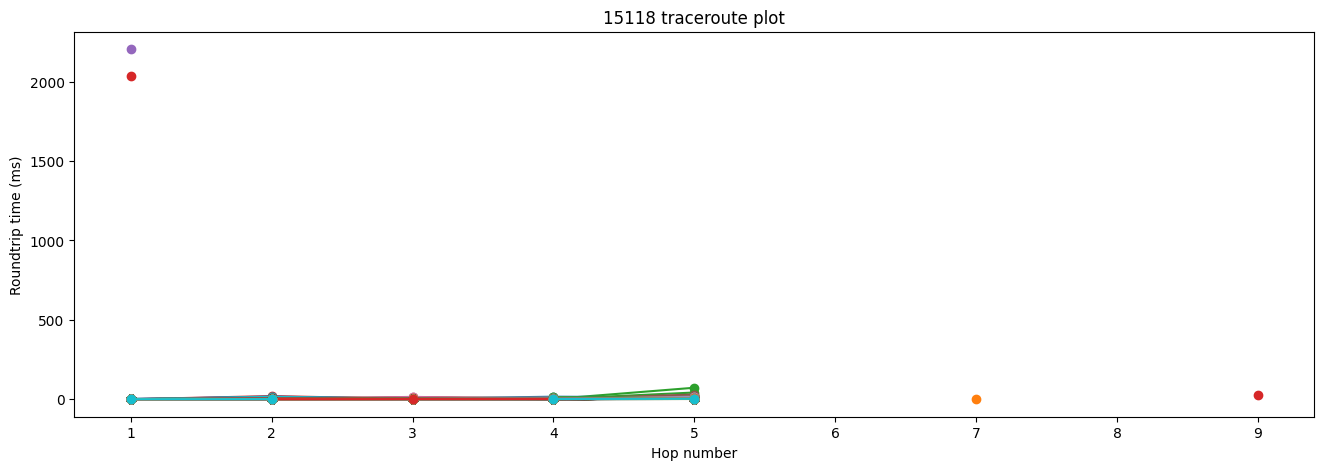

In [19]:
# what are the general patterns for a traceroute from a single probe_id to that destination 
one_probe = hop_df[hop_df['prb_id'] == 15118]

# Get the unique traceroute indices
indices = one_probe.index.unique()

# Plot all traceroute groups on one plot
fig, ax = plt.subplots()

for idx in indices:
    group = one_probe[one_probe.index == idx]
    hops = group['hop']
    rtt = group['avg_rtt']
    ip = group['unique_ips']
    ax.plot(hops,rtt, marker='o',label=f'Traceroute group {idx}')
    
ax.set_xlabel('Hop number')
ax.set_ylabel('Roundtrip time (ms)')
ax.set_title('15118 traceroute plot')
plt.show()    

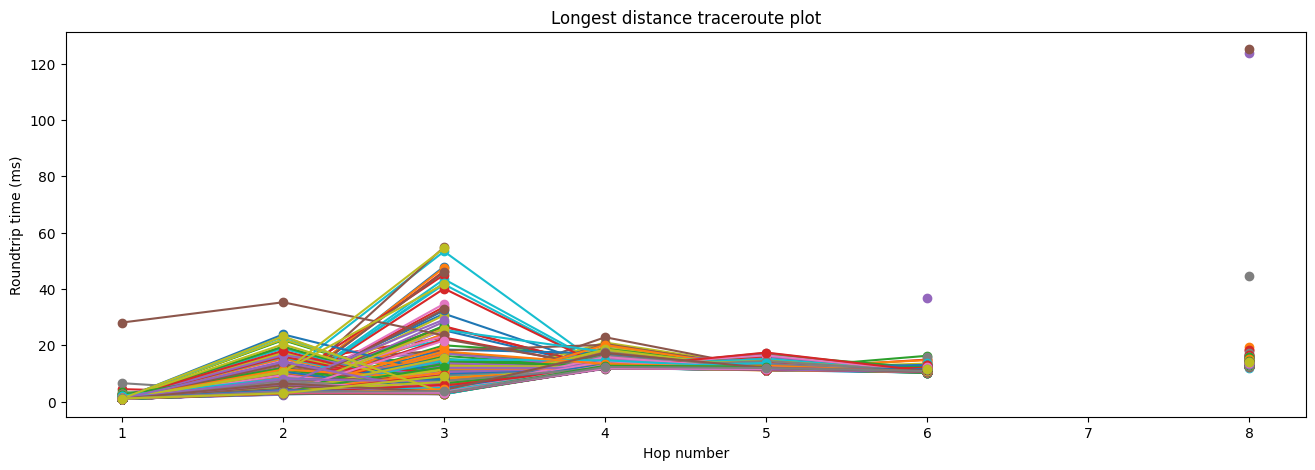

In [20]:
test_df = int_df[(int_df['prb_id'] == 55787) & (int_df['dst_addr'] == "81.34.11.86")]

# Get the unique traceroute indices
indices = test_df.index.unique()

# Plot all traceroute groups on one plot
fig, ax = plt.subplots()

for idx in indices:
    group = test_df[test_df.index == idx]
    hops = group['hop']
    rtt = group['avg_rtt']
    ip = group['unique_ips']
    ax.plot(hops,rtt, marker='o',label=f'Traceroute group {idx}')
    
ax.set_xlabel('Hop number')
ax.set_ylabel('Roundtrip time (ms)')
ax.set_title('Longest distance traceroute plot')
plt.show() 

In [21]:
# Select the row with the largest distance
max_distance_row = distance_df.loc[distance_df['distance'].idxmax()]

# Print the row with the largest distance
max_distance_row


source_prb_id            3.362700e+04
source_longitude         2.188500e+00
source_latitude          4.140050e+01
destination_prb_id       1.004200e+06
destination_longitude   -1.550250e+01
destination_latitude     2.802750e+01
distance                 2.188880e+03
Name: 3, dtype: float64

In [22]:
src_prb = int(max_distance_row.iloc[0])
dst_prb = int(max_distance_row.iloc[3])

longdist_df = int_df[(int_df['prb_id'] == src_prb) & (int_df['dst_id'] == str(dst_prb))]

# Print the DataFrame to see the result
longdist_df

,fw,mver,lts,endtime,dst_name,dst_addr,src_addr,proto,af,size,...,dst_id,dst_names,src_names,Hour,distance,hop,hop_ip,rtt,unique_ips,avg_rtt
30331,4770,NaN,24,1683307692,88.24.67.177,88.24.67.177,192.168.1.8,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,19,2188.880094,1,"[192.168.1.1, 192.168.1.1, 192.168.1.1]","[0.581, 0.437, 0.537]",[192.168.1.1],0.518333
30331,4770,NaN,24,1683307692,88.24.67.177,88.24.67.177,192.168.1.8,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,19,2188.880094,2,"[81.46.38.142, 81.46.38.142, 81.46.38.142]","[2.121, 1.973, 4.033]",[81.46.38.142],2.709000
30331,4770,NaN,24,1683307692,88.24.67.177,88.24.67.177,192.168.1.8,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,19,2188.880094,3,"[81.46.34.81, 81.46.34.81, 81.46.34.81]","[2.361, 2.191, 2.062]",[81.46.34.81],2.204667
30331,4770,NaN,24,1683307692,88.24.67.177,88.24.67.177,192.168.1.8,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,19,2188.880094,4,"[81.46.34.133, 81.46.34.133, 81.46.34.133]","[35.332, 35.292, 35.282]",[81.46.34.133],35.302000
30331,4770,NaN,24,1683307692,88.24.67.177,88.24.67.177,192.168.1.8,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,19,2188.880094,5,"[80.58.96.1, 80.58.96.1, 80.58.96.1]","[39.485, 41.118, 38.794]",[80.58.96.1],39.799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60659,4770,NaN,31,1704988708,88.24.67.177,88.24.67.177,192.168.1.54,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,16,2188.880094,6,"[80.58.106.57, 80.58.106.57, 80.58.106.57]","[37.48, 37.764, 37.72]",[80.58.106.57],37.654667
60659,4770,NaN,31,1704988708,88.24.67.177,88.24.67.177,192.168.1.54,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,16,2188.880094,7,"[81.46.1.129, 81.46.1.129, 81.46.1.129]","[36.242, 35.802, 43.008]",[81.46.1.129],38.350667
60659,4770,NaN,31,1704988708,88.24.67.177,88.24.67.177,192.168.1.54,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,16,2188.880094,8,"[81.41.250.109, 81.41.250.109, 81.41.250.109]","[39.722, 39.425, 40.176]",[81.41.250.109],39.774333
60659,4770,NaN,31,1704988708,88.24.67.177,88.24.67.177,192.168.1.54,ICMP,4,48,...,1004200,Canary Islands,src_Barcelona,16,2188.880094,9,"[None, None, None]","[nan, nan, nan]",[None],NaN


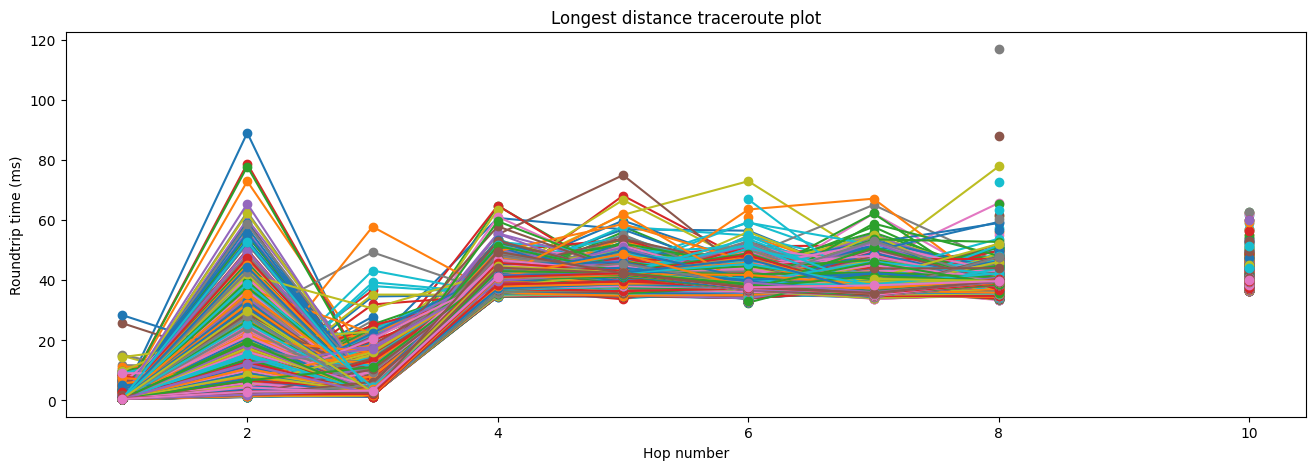

In [23]:
# plotting the hops for the largest distance

# Get the unique traceroute indices
indices = longdist_df.index.unique()

# Plot all traceroute groups on one plot
fig, ax = plt.subplots()

for idx in indices:
    group = longdist_df[longdist_df.index == idx]
    hops = group['hop']
    rtt = group['avg_rtt']
    ip = group['unique_ips']
    ax.plot(hops,rtt, marker='o',label=f'Traceroute group {idx}')
    
ax.set_xlabel('Hop number')
ax.set_ylabel('Roundtrip time (ms)')
ax.set_title('Longest distance traceroute plot')
plt.show()    

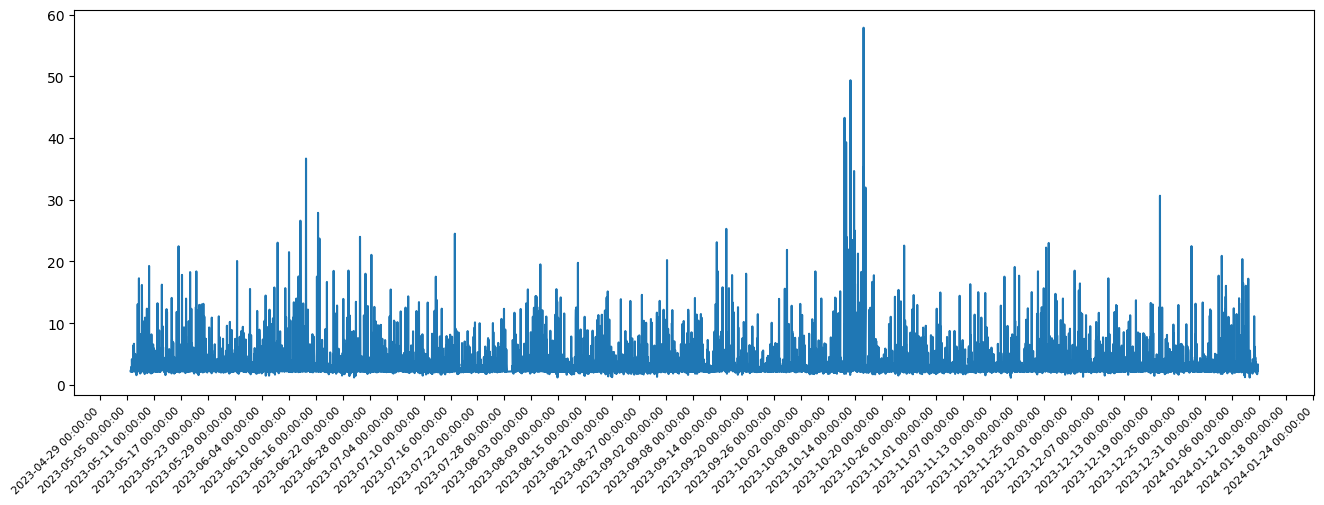

In [24]:
# temporal plot for the the hop with the largest round trip times 
import matplotlib.dates as mdates

long_hop = longdist_df[longdist_df['hop']==3]
plt.plot(long_hop["new_time"],long_hop["avg_rtt"])

# Customize the x-axis tick labels

date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(50))

# Display the plot
plt.show()

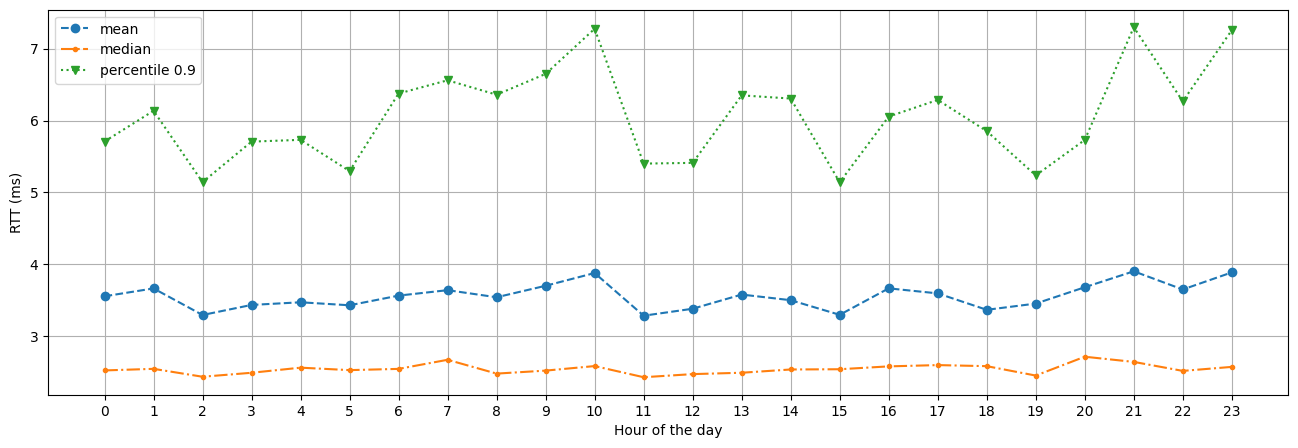

In [25]:
#plot the delay as function of hour of the day for a given hop
rtt_avg_hour = long_hop.groupby(['Hour'])['avg_rtt']

hop_mean   = rtt_avg_hour.mean()
hop_median = rtt_avg_hour.median()
hop_q9     = rtt_avg_hour.quantile(q=.9)
# hop_q95    = rtt_avg_hour.quantile(q=.95)
hop_max    = rtt_avg_hour.max()


plt.plot(hop_mean, 'o--', label='mean')
plt.plot(hop_median, '.-.', label='median')
plt.plot(hop_q9, 'v:',label='percentile 0.9')

# Display the plot
plt.legend()
plt.grid()
plt.xlabel('Hour of the day')
plt.ylabel('RTT (ms)')
plt.xticks(np.arange(0, 24, 1.0))
plt.show()

In [26]:
num_samples = rtt_avg_hour.count()
num_samples[0]

300